### Import packages

In [1]:
# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# data structure
import pandas as pd

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

### Define all Variables

In [2]:
# Cylindrical storage tank properties
Q_roof = 0 # Roof heat ingress / W
T_air = 298.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 8e-2 # W/m2/K
U_V = 8e-2 # W/m2/K

# Specify wall heat partitioning fraction
eta_w= 0.9

# Specify tank operating pressure
P = 100000 # Pa

### Variables of interest

# Vertically orientated cylindrical tank volume
V_tank = 165000 #m^3 | 

# Initial liquid filling / Dimensionless
LFs = [0.3, 0.95] # values of 0.95 and 0.30

# especify compound in the tank
Compound = "ammonia" # hydrogen, methane, ammonia, nitrogen

# Especify if the data should be saved in the output.xlxs excel
sv = True

In [3]:
# Define evaporation time to simulate
hours = [24 * 30, 24 * 2] #[24 * 2, 24 * 30]
evap_times = [x * 3600 for x in hours]
# helpful variables
mults = [1 , 2 , 3]
# Thickness of the in % of the internal diameter
ST = 1.02

# Show sim duration
print(f"Simulation time: {hours} h")

Simulation time: [720, 48] h


In [4]:
# Define objective function
def BOR_function(a):
    # Update aspect ratio
    # Calculate internal diameter
    d_i = ((4 * V_tank)/(np.pi * a))**(1/3) # internal diameter / m
    d_o = d_i * ST # external diameter / m
    
    # Initialize tank
    mid_tank = Tank(d_i, d_o, V_tank, LF)

    # Set cryogen
    mid_tank.cryogen = Cryogen(name = Compound)
    
    mid_tank.cryogen.set_coolprops(P)

    # Heat flux
    q_b = mult * U_L * (T_air-mid_tank.cryogen.T_sat)  
    
    Q_b_fixed = q_b * mid_tank.A_T
    
    #Set Heat transfer propierties
    mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed, Q_roof, eta_w)

    mid_tank.U_roof = 0
    
    # Define vertical spacing
    # dz = 0.05 # 0.1 0.01 0.001
    # Calculate number of nodes
    
    # n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))

    n_z = 20
    
    # Define dimensionless computational grid
    mid_tank.z_grid = np.linspace(0, 1, n_z)
    
    # Execute simulation
    mid_tank.evaporate(evap_time)
    
    # return BOR
    
    print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))
    
    return mid_tank.BOR()

In [5]:
from scipy.optimize import Bounds, minimize

# Minimum and maximum practical ranges
# of the aspect ratio
bounds = Bounds([0.1], [5])

# Initial Aspect Ratio to optimise
x0 = 1 

# Solution of the optimization 
for mult in mults:
    for LF in LFs:
        for evap_time in evap_times:
            print(f"\nOptimum search for Tank Volume: {V_tank}, Liquid Filling: {LF*100}%, Compound: {Compound}, time: {evap_time/3600} hrs")
            res = minimize(BOR_function, x0, method='trust-constr',tol=1e-8 , options={'verbose': 1}, bounds=bounds)
            
            # Calculate internal diameter for optimum
            d_i = ((4 * V_tank)/(np.pi * res.x[0]))**(1/3) # internal diameter / m
            d_o = d_i * ST # external diameter / m
            
            # Initialize optimum tank
            mid_tank = Tank(d_i, d_o, V_tank, LF)
            
            # Set cryogen
            mid_tank.cryogen = Cryogen(name = Compound)
            
            mid_tank.cryogen.set_coolprops(P)
            
            q_b = mult * U_L * (T_air-mid_tank.cryogen.T_sat) # Heat flux proportional to the T diff of the cryogen.
            
            Q_b_fixed= q_b * mid_tank.A_T
            
            mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed, Q_roof, eta_w)
            
            mid_tank.U_roof = U_V
            
            # Data table
            
            table = [[Compound, mid_tank.V, mid_tank.LF, f"{evap_time/3600} hrs", f"{res.fun}", f"{res.x[0]}",
                        P, T_air, mid_tank.d_i, mid_tank.d_o, mid_tank.l, U_L, U_V, eta_w, mid_tank.Q_b, q_b]]
            
            # structure the data table
            
            data_table = pd.DataFrame(table, columns = ["Cryogen", "Volume", "Liquid Filling","Simulation","BOR","Aspect Ratio"
                                                    , "Pressure (P)", "T_air (K)", "d_i", "d_o", "Height", "U_L", "U_V", "Eta_w","Q_b","q_b"])
            #print(Data_table)
            
            if sv:
                # Send Data table to excel
                # Try to load the existing Excel file
                try:
                    data_excel = pd.read_excel('Final.xlsx')
                    
                    # Append the row
                    data_excel = pd.concat([data_excel, data_table], ignore_index = True)
                    
                    # Save the updated DataFrame back to the Excel file
                    data_excel.to_excel('Final.xlsx', index = False)
                except:
                    #In case the file doesnt exist it is created
                    data_table.to_excel('Final.xlsx', index = False)
                print("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nData was saved.\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            else:
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nData was not saved.\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                # Print a summary of the optimum if it is found
            if res.success:
                print(f"\nOptimum found for Tank Volume: {V_tank}, Liquid Filling: {LF*100}%, Compound: {Compound}" + 
                      f"\nAspect Ratio = {res.x[0]:.3f}" + f"\nBOR = {res.fun*100:.3f} %")


Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia, time: 720.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.046e-04
a = 1.000, BOR=1.046e-04
a = 1.067, BOR=1.051e-04
a = 1.067, BOR=1.051e-04
a = 0.594, BOR=1.035e-04
a = 0.594, BOR=1.035e-04
a = 0.823, BOR=1.035e-04
a = 0.823, BOR=1.035e-04
a = 0.762, BOR=1.033e-04
a = 0.762, BOR=1.033e-04
a = 0.686, BOR=1.032e-04
a = 0.686, BOR=1.032e-04
a = 0.693, BOR=1.032e-04
a = 0.693, BOR=1.032e-04
a = 0.690, BOR=1.032e-04
a = 0.690, BOR=1.032e-04
`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 16, CG iterations: 7, optimality: 8.69e-10, constraint violation: 0.00e+00, execution time: 3.4e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia
Aspect Ratio = 0.690
BOR = 0.010 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia, time: 48.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.154e-04
a = 1.000, BOR=1.154e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 0.105, BOR=1.527e-04
a = 0.105, BOR=1.527e-04
a = 0.105, BOR=1.527e-04
a = 0.105, BOR=1.527e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.067, BOR=1.164e-04
a = 1.061, BOR=1.163e-04
a = 1.061, BOR=1.163e-04
a = 0.105, BOR=1.527e-04
a = 0.105, BOR=1.527e-04
a = 1.040, BOR=1.160e-04
a = 1.040, BOR=1.160e-04
a = 1.019, BOR=1.157e-04
a = 1.019, BOR=1.157e-04
a = 0.123, BOR=1.439e-04
a = 0.123, BOR=1.439e-04
a = 0.992, BOR=1.153e-04
a = 0.992, BOR=1.153e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.241, BOR=1.198e-04
a = 0.241, BOR=1.198e-04
a = 0.241, BOR=1.198e-04
a = 0.241, BOR=1.198e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04


/home/milcaito/anaconda3/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.967, BOR=1.150e-04
a = 0.965, BOR=1.149e-04
a = 0.965, BOR=1.149e-04
a = 0.206, BOR=1.238e-04
a = 0.206, BOR=1.238e-04
a = 0.206, BOR=1.238e-04
a = 0.206, BOR=1.238e-04
a = 0.906, BOR=1.142e-04
a = 0.906, BOR=1.142e-04
a = 0.855, BOR=1.135e-04
a = 0.855, BOR=1.135e-04
a = 0.476, BOR=1.112e-04
a = 0.476, BOR=1.112e-04
a = 0.639, BOR=1.114e-04
a = 0.639, BOR=1.114e-04
a = 0.591, BOR=1.111e-04
a = 0.591, BOR=1.111e-04
a = 0.535, BOR=1.110e-04
a = 0.535, BOR=1.110e-04
a = 0.545, BOR=1.110e-04
a = 0.545, BOR=1.110e-04
a = 0.539, BOR=1.110e-04
a = 0.539, BOR=1.110e-04
`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 72, CG iterations: 32, optimality: 1.07e-09, constraint violation: 0.00e+00, execution time: 4.7e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Vo

/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=3.881e-05
a = 1.000, BOR=3.881e-05
a = 1.067, BOR=3.916e-05
a = 1.067, BOR=3.916e-05
a = 0.216, BOR=4.005e-05
a = 0.216, BOR=4.005e-05
a = 0.986, BOR=3.874e-05
a = 0.986, BOR=3.874e-05
a = 0.917, BOR=3.839e-05
a = 0.917, BOR=3.839e-05
a = 0.364, BOR=3.733e-05
a = 0.364, BOR=3.733e-05
a = 0.777, BOR=3.772e-05
a = 0.777, BOR=3.772e-05
a = 0.694, BOR=3.738e-05
a = 0.694, BOR=3.738e-05
a = 0.430, BOR=3.701e-05
a = 0.430, BOR=3.701e-05
a = 0.558, BOR=3.699e-05
a = 0.558, BOR=3.699e-05
a = 0.527, BOR=3.694e-05
a = 0.527, BOR=3.694e-05
a = 0.496, BOR=3.693e-05
a = 0.496, BOR=3.693e-05
`gtol` termination condition is satisfied.
Number of iterations: 22, function evaluations: 24, CG iterations: 11, optimality: 1.10e-09, constraint violation: 0.00e+00, execution time: 4.5e+03 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia
Aspect Ratio = 0.496
BOR = 0.004 %

Optimum s

/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=3.882e-05
a = 1.000, BOR=3.882e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 0.208, BOR=4.034e-05
a = 0.208, BOR=4.034e-05
a = 0.208, BOR=4.034e-05
a = 0.208, BOR=4.034e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05


/home/milcaito/anaconda3/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.067, BOR=3.917e-05
a = 1.066, BOR=3.917e-05
a = 1.066, BOR=3.917e-05
a = 1.066, BOR=3.917e-05
a = 1.066, BOR=3.917e-05
a = 1.066, BOR=3.917e-05
a = 1.066, BOR=3.917e-05
a = 1.046, BOR=3.906e-05
a = 1.046, BOR=3.906e-05
a = 1.026, BOR=3.896e-05
a = 1.026, BOR=3.896e-05
a = 0.356, BOR=3.738e-05
a = 0.356, BOR=3.738e-05
a = 0.733, BOR=3.753e-05
a = 0.733, BOR=3.753e-05
a = 0.631, BOR=3.716e-05
a = 0.631, BOR=3.716e-05
a = 0.454, BOR=3.696e-05
a = 0.454, BOR=3.696e-05
a = 0.533, BOR=3.695e-05
a = 0.533, BOR=3.695e-05
a = 0.505, BOR=3.693e-05
a = 0.505, BOR=3.693e-05
a = 0.498, BOR=3.692e-05
a = 0.498, BOR=3.692e-05
`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 50, CG iterations: 32, optimality: 6.82e-09, constraint vio

/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.299e-04
a = 1.000, BOR=1.299e-04
a = 1.067, BOR=1.294e-04
a = 1.067, BOR=1.294e-04
a = 1.288, BOR=1.285e-04
a = 1.288, BOR=1.285e-04
a = 1.399, BOR=1.284e-04
a = 1.399, BOR=1.284e-04
a = 1.414, BOR=1.284e-04
a = 1.414, BOR=1.284e-04
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 10, CG iterations: 4, optimality: 5.31e-09, constraint violation: 0.00e+00, execution time: 1.5e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia
Aspect Ratio = 1.414
BOR = 0.013 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia, time: 48.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.397e-04
a = 1.000, BOR=1.397e-04
a = 1.067, BOR=1.396e-04
a = 1.067, BOR=1.396e-04
a = 1.086, BOR=1.396e-04
a = 1.086, BOR=1.396e-04
a = 1.082, BOR=1.396e-04
a = 1.082, BOR=1.396e-04
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 8, CG iterations: 3, optimality: 1.20e-09, constraint violation: 0.00e+00, execution time:  3.3 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia
Aspect Ratio = 1.082
BOR = 0.014 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia, time: 720.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=4.648e-05
a = 1.000, BOR=4.648e-05
a = 1.067, BOR=4.651e-05
a = 1.067, BOR=4.651e-05
a = 0.994, BOR=4.648e-05
a = 0.994, BOR=4.648e-05
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 1.93e-09, constraint violation: 0.00e+00, execution time: 1.6e+02 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia
Aspect Ratio = 0.994
BOR = 0.005 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia, time: 48.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=4.649e-05
a = 1.000, BOR=4.649e-05
a = 1.067, BOR=4.652e-05
a = 1.067, BOR=4.652e-05
a = 0.986, BOR=4.649e-05
a = 0.986, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.993, BOR=4.649e-05
a = 0.993, BOR=4.649e-05
a = 0.991, BOR=4.649e-05
a = 0.991, BOR=4.649e-05
a = 0.991, BOR=4.649e-05
a = 0.991, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05


/home/milcaito/anaconda3/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
a = 0.989, BOR=4.649e-05
`xtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 62, CG it

/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.552e-04
a = 1.000, BOR=1.552e-04
a = 1.067, BOR=1.537e-04
a = 1.067, BOR=1.537e-04
a = 1.464, BOR=1.483e-04
a = 1.464, BOR=1.483e-04
a = 1.773, BOR=1.466e-04
a = 1.773, BOR=1.466e-04
a = 1.997, BOR=1.461e-04
a = 1.997, BOR=1.461e-04
a = 2.117, BOR=1.461e-04
a = 2.117, BOR=1.461e-04
a = 2.155, BOR=1.460e-04
a = 2.155, BOR=1.460e-04
a = 2.159, BOR=1.460e-04
a = 2.159, BOR=1.460e-04
`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 16, CG iterations: 7, optimality: 1.35e-09, constraint violation: 0.00e+00, execution time: 2.5e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia
Aspect Ratio = 2.159
BOR = 0.015 %

Optimum search for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia, time: 48.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=1.640e-04
a = 1.000, BOR=1.640e-04
a = 1.067, BOR=1.628e-04
a = 1.067, BOR=1.628e-04
a = 1.386, BOR=1.600e-04
a = 1.386, BOR=1.600e-04
a = 1.525, BOR=1.596e-04
a = 1.525, BOR=1.596e-04
a = 1.632, BOR=1.596e-04
a = 1.632, BOR=1.596e-04
a = 1.630, BOR=1.596e-04
a = 1.630, BOR=1.596e-04
`gtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 12, CG iterations: 5, optimality: 9.04e-10, constraint violation: 0.00e+00, execution time:  4.9 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 30.0%, Compound: ammonia
Aspect Ratio = 1.630
BOR = 0.016 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia, time: 720.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=5.415e-05
a = 1.000, BOR=5.415e-05
a = 1.067, BOR=5.386e-05
a = 1.067, BOR=5.386e-05
a = 1.332, BOR=5.326e-05
a = 1.332, BOR=5.326e-05
a = 1.430, BOR=5.320e-05
a = 1.430, BOR=5.320e-05
a = 1.477, BOR=5.319e-05
a = 1.477, BOR=5.319e-05
a = 1.482, BOR=5.319e-05
a = 1.482, BOR=5.319e-05
`gtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 12, CG iterations: 5, optimality: 5.21e-09, constraint violation: 0.00e+00, execution time: 4.1e+02 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia
Aspect Ratio = 1.482
BOR = 0.005 %

Optimum search for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia, time: 48.0 hrs


/tmp/ipykernel_70232/3277189072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))


a = 1.000, BOR=5.416e-05
a = 1.000, BOR=5.416e-05
a = 1.067, BOR=5.387e-05
a = 1.067, BOR=5.387e-05
a = 1.341, BOR=5.326e-05
a = 1.341, BOR=5.326e-05
a = 1.432, BOR=5.321e-05
a = 1.432, BOR=5.321e-05
a = 1.472, BOR=5.320e-05
a = 1.472, BOR=5.320e-05
a = 1.480, BOR=5.320e-05
a = 1.480, BOR=5.320e-05
`gtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 12, CG iterations: 5, optimality: 4.38e-09, constraint violation: 0.00e+00, execution time: 5.1e+01 s.

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Data was saved.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Optimum found for Tank Volume: 165000, Liquid Filling: 95.0%, Compound: ammonia
Aspect Ratio = 1.480
BOR = 0.005 %


In [12]:
#Boil-off ratio list for plotting
BOR_plot = []

# Generate aspect ratio range
AR = np.linspace(0.2,2,30)

LF=0.3
evap_time= 24 * 30 * 3600
# Generate tanks in Aspect Ratio range
for a in AR:
    # Update aspect ratio
    # Calculate internal diameter
    d_i = ((4 * V_tank)/(np.pi * a))**(1/3) # internal diameter / m
    d_o = d_i * ST # external diameter / m
    
    # Initialize tank
    mid_tank = Tank(d_i, d_o, V_tank, LF)

    # Set cryogen
    mid_tank.cryogen = Cryogen(name = Compound)
    
    mid_tank.cryogen.set_coolprops(P)
    
    mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed = None, Q_roof = 0, eta_w = 0.9)

    mid_tank.U_roof = 0
    
    
    
    # Define vertical spacing
    # dz = 0.1

    # Calculate number of nodes
    # n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))
    n_z = 10
    # Define dimensionless computational grid
    mid_tank.z_grid = np.linspace(0, 1, n_z)
    # Execute simulation
    mid_tank.evaporate(evap_time)
    
    # Calculate BOR
    
    # Save BOR value
    BOR_plot.append(mid_tank.BOR())
    
    print("a = %.3f, BOR=%.3e" % (a, mid_tank.BOR()))
    # print("BOR = %.3f %% | B_l = %.3f " % (BOR * 100, mid_tank.b_l_dot))
    # print(f"Aspect Ratio:{a:.3f}, Altura: {mid_tank.l:.3f} , Diametro interno:{mid_tank.d_i:.3f}, Volumen:{mid_tank.V} \n")
print("Simulation end")

a = 0.200, BOR=1.218e-04
a = 0.262, BOR=1.142e-04
a = 0.324, BOR=1.098e-04
a = 0.386, BOR=1.072e-04
a = 0.448, BOR=1.056e-04
a = 0.510, BOR=1.046e-04
a = 0.572, BOR=1.040e-04
a = 0.634, BOR=1.038e-04
a = 0.697, BOR=1.037e-04
a = 0.759, BOR=1.039e-04
a = 0.821, BOR=1.041e-04
a = 0.883, BOR=1.044e-04
a = 0.945, BOR=1.048e-04
a = 1.007, BOR=1.052e-04
a = 1.069, BOR=1.057e-04
a = 1.131, BOR=1.062e-04
a = 1.193, BOR=1.068e-04
a = 1.255, BOR=1.073e-04
a = 1.317, BOR=1.079e-04
a = 1.379, BOR=1.084e-04
a = 1.441, BOR=1.090e-04
a = 1.503, BOR=1.096e-04
a = 1.566, BOR=1.102e-04
a = 1.628, BOR=1.108e-04
a = 1.690, BOR=1.114e-04
a = 1.752, BOR=1.120e-04
a = 1.814, BOR=1.126e-04
a = 1.876, BOR=1.132e-04
a = 1.938, BOR=1.138e-04
a = 2.000, BOR=1.143e-04
Simulation end


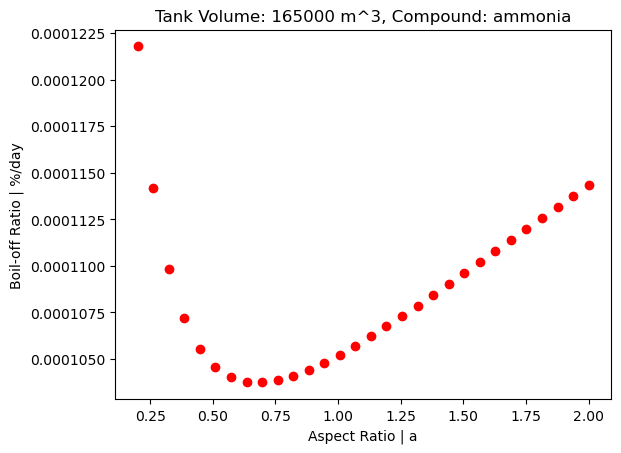

In [13]:
# Create a plot
plt.plot(AR, BOR_plot,"ro")

# Add labels and title
plt.xlabel('Aspect Ratio | a')
plt.ylabel('Boil-off Ratio | %/day')
plt.title(f'Tank Volume: {V_tank} m^3, Compound: {Compound}')


# Save the plot
plt.savefig(f'{Compound}/V_{V_tank}_LF_{LF*100}_C_{Compound}_final2.png')

# Display the plot
plt.show()